# Evaluate mock community classification accuracy
The purpose of this notebook is to evaluate taxonomic classification accuracy of mock communities using different classification methods.

Prepare the environment
-----------------------

First we'll import various functions that we'll need for generating the report. 

In [1]:
%matplotlib inline
from os.path import join, exists, expandvars
import pandas as pd
from IPython.display import display, Markdown
import seaborn.xkcd_rgb as colors
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           boxplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           beta_diversity_pcoa,
                                           average_distance_boxplots,
                                           rank_optimized_method_performance_by_dataset)
from tax_credit.eval_framework import (evaluate_results,
                                       method_by_dataset_a1,
                                       parameter_comparisons,
                                       merge_expected_and_observed_tables,
                                       filter_df)

Configure local environment-specific values
-------------------------------------------

**This is the only cell that you will need to edit to generate basic reports locally.** After editing this cell, you can run all cells in this notebook to generate your analysis report. This will take a few minutes to run, as results are computed at multiple taxonomic levels.

Values in this cell will not need to be changed, with the exception of ``project_dir``, to generate the default results contained within tax-credit. To analyze results separately from the tax-credit precomputed results, other variables in this cell will need to be set.

In [2]:
## project_dir should be the directory where you've downloaded (or cloned) the 
## tax-credit repository. 
project_dir = join('..', '..')

## expected_results_dir contains expected composition data in the structure
## expected_results_dir/<dataset name>/<reference name>/expected/
expected_results_dir = join(project_dir, "data/precomputed-results/", "mock-community")

## mock_results_fp designates the files to which summary results are written.
## If this file exists, it can be read in to generate results plots, instead
## of computing new scores.
mock_results_fp = join(expected_results_dir, 'mock_results.tsv')

## results_dirs should contain the directory or directories where
## results can be found. By default, this is the same location as expected 
## results included with the project. If other results should be included, 
## absolute paths to those directories should be added to this list.
results_dirs = [expected_results_dir]

## directory containing mock community data, e.g., feature table without taxonomy
mock_dir = join(project_dir, "data", "mock-community")

## Minimum number of times an OTU must be observed for it to be included in analyses. Edit this
## to analyze the effect of the minimum count on taxonomic results.
min_count = 1

## Define the range of taxonomic levels over which to compute accuracy scores.
## The default given below will compute order (level 2) through species (level 6)
taxonomy_level_range = range(2,7)

In [5]:
dataset_ids = ['mock-1', 'mock-2', 'mock-3', 'mock-4', 'mock-5', 'mock-7', 'mock-8', 
               'mock-12', 'mock-16', 'mock-18', 'mock-19', 'mock-20', 'mock-21', 
               'mock-22', 'mock-23',  'mock-26-ITS1', 'mock-26-ITS9',
               'mock-9', 'mock-10', 'mock-24']
reference_ids = ['gg_13_8_otus_full', 'gg_13_8_otus_amplicon',
                 'unite_20.11.2016_clean_full']

Find mock community pre-computed tables, expected tables, and "query" tables
----------------------------------------------------------------------------

Next we'll use the paths defined above to find all of the tables that will be compared. These include the *pre-computed result* tables (i.e., the ones that the new methods will be compared to), the *expected result* tables (i.e., the tables containing the known composition of the mock microbial communities), and the *query result* tables (i.e., the tables generated with the new method(s) that we want to compare to the *pre-computed result* tables).

**Note**: if you have added additional methods to add, set `append=True`. If you are attempting to recompute pre-computed results, set `force=True`.

This cell will take a few minutes to run if new results are being added, so hold onto your hat. If you are attempting to re-compute everything, it may take an hour or so, so go take a nap.

In [6]:
mock_results = evaluate_results(results_dirs, 
                                expected_results_dir, 
                                mock_results_fp, 
                                mock_dir,
                                dataset_ids=dataset_ids,
                                reference_ids=reference_ids,
                                taxonomy_level_range=range(2,7), 
                                min_count=min_count,
                                taxa_to_keep=None, 
                                md_key='taxonomy', 
                                subsample=False,
                                per_seq_precision=True,
                                exclude=['other'],
                                method_ids=['naive-bayes', 'naive-bayes-bespoke'],
                                append=False,
                                force=False)

../../data/precomputed-results/mock-community/mock_results.tsv already exists.
Reading in pre-computed evaluation results.
To overwrite, set force=True
Results have been filtered to only include datasets or reference databases or methods or parameters that are explicitly set by results params. To disable this function and load all results, set dataset_ids and reference_ids and method_ids and parameter_ids to None.


In [7]:
mock_results['Reference'].unique()

array(['gg_13_8_otus_amplicon', 'gg_13_8_otus_full',
       'unite_20.11.2016_clean_full'], dtype=object)

Restrict analyses to a set of datasets or references: e.g., exclude taxonomy assignments made for purpose of reference database comparisons. This can be performed as shown below — alternatively, specific reference databases, datasets, methods, or parameters can be chosen by setting dataset_ids, reference_ids, method_ids, and parameter_ids in the evaluate_results command above.

In [8]:
#mock_results = filter_df(mock_results, column_name='Reference',
#                         values=['gg_13_8_otus_amplicon', 'gg_13_8_otus_read', 'gg_13_8_otus_full'],
#                         exclude=False)
mock_results = mock_results.reset_index(drop=True)

Compute and summarize precision, recall, and F-measure for mock communities
----------------------------------------------------------------------------------------

In this evaluation, we compute and summarize precision, recall, and F-measure of each result (pre-computed and query) based on the known composition of the mock communities. We then summarize the results in two ways: first with boxplots, and second with a table of the top methods based on their F-measures. **Higher scores = better accuracy**

As a first step, we will evaluate **average** method performance at each taxonomic level for each method within each reference dataset type.

**Note that, as parameter configurations can cause results to vary widely, average results are not a good representation of the "best" results. See [here](#Optimized-method-performance) for results using optimized parameters for each method.**

First we will define our [color palette](http://matplotlib.org/examples/color/named_colors.html) and the variables we want to plot. Via seaborn, we can apply the [xkcd crowdsourced color names](https://xkcd.com/color/rgb.txt). If that still doesn't match your hue, use hex codes.

In [9]:
color_pallette={
    'naive-bayes': 'blue', 'naive-bayes-bespoke': 'orange'
}

y_vars = ["Precision", "Recall", "F-measure", "Taxon Accuracy Rate", "Taxon Detection Rate"]

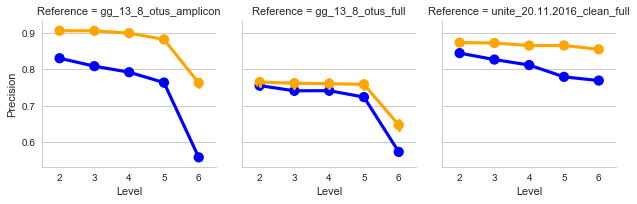

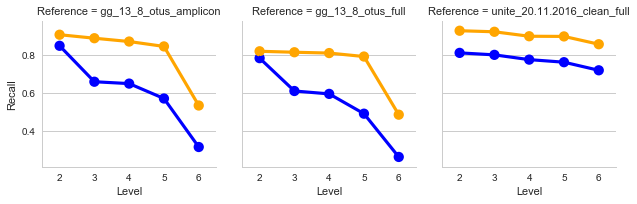

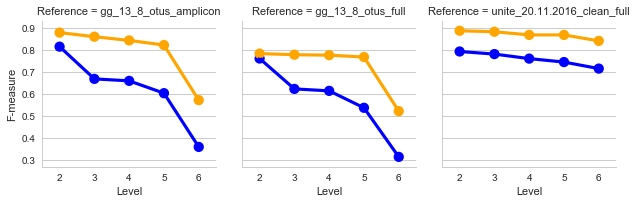

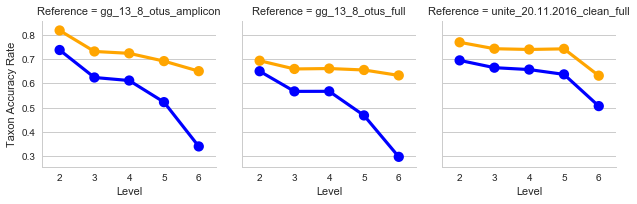

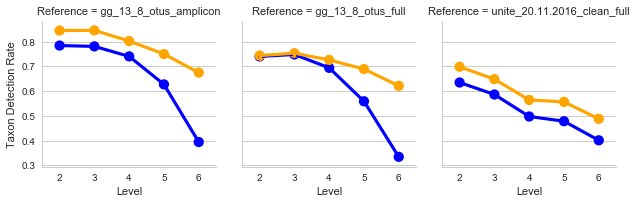

In [10]:
pointplot_from_data_frame(mock_results, "Level", y_vars, 
                          group_by="Reference", color_by="Method",
                          color_pallette=color_pallette)

### CART Analysis
In this section we will use Classification and Regression Trees to try to pick good parameters for the naïve Bayes classifier. In each case, we pick the path to the classification leaf that yields the highest expected F-measure. Also, we unconventionally turn of pruning, so that all parameters are sepecified. This has the effect of picking arbitrary parameters towards the leaves of the decision tree where it doesn't matter as much which parameters we choose.

This section requires the additional dependencies of `rpy2` in Python and `rpart` in R. If you do not wish to install those dependencies, skip the CART Analysis section.

In [11]:
mock_results['Reference'].unique()

array(['gg_13_8_otus_amplicon', 'gg_13_8_otus_full',
       'unite_20.11.2016_clean_full'], dtype=object)

In [12]:
from itertools import product

from pandas import DataFrame, concat, to_numeric
import rpy2

In [13]:
%load_ext rpy2.ipython

In [14]:
%R require(rpart)

/Users/benkaehler/miniconda3/envs/qiime2-2017.5/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: rpart

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

#### Split the Parameter String and Aggregate by Community

In [15]:
columns = ['Alpha', 'Class-Prior', 'Analyzer', 'N-Features', 'kmerlen', 'Confidence']
def decode_params(p):
    p = p.split(':')
    if p[1] != 'prior':
        p.insert(1, 'uniform')
    p[-2] = eval(p[-2])[0]
    return p
params = DataFrame((decode_params(s) for s in mock_results['Parameters']), columns=columns)
keepers = ['Dataset', 'Level', 'Reference', 'Method']
metrics = ['Precision', 'Recall', 'F-measure', 'Taxon Accuracy Rate', 'Taxon Detection Rate']
raw_param_results = concat([mock_results[keepers + metrics], params], axis=1)
raw_param_results = raw_param_results.apply(to_numeric, errors='ignore')
param_results = raw_param_results.groupby(keepers + columns, as_index=False).mean()
param_results.kmerlen = param_results.kmerlen.astype(int)
len(param_results)

37800

## k-mer length picker

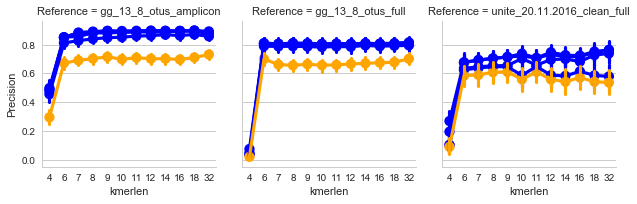

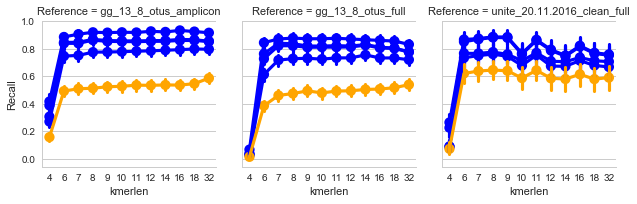

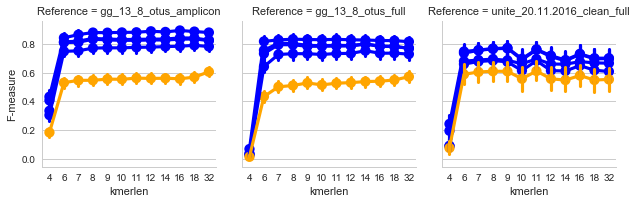

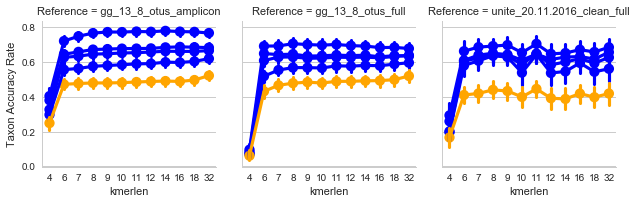

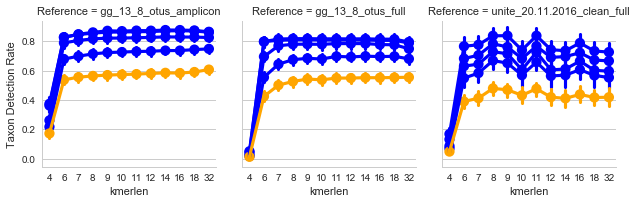

In [18]:
level_pallete = {n:'blue' for n in range(2,6)}
level_pallete[6] = 'orange'
pointplot_from_data_frame(param_results, "kmerlen", y_vars, 
                          group_by="Reference", color_by="Level",
                          color_pallette=level_pallete)

In [21]:
%%R
recommend_params <- function(data, levels, references, method)
{
    data = data[data[,"Reference"] %in% references,]
    data = data[data[,"Level"] %in% levels,]
    data = data[data[,"Method"] == method,]
    fit <- rpart(F.measure ~ Confidence + kmerlen + N.Features + Reference, 
                 data=data,
                 method="anova",
                 control=rpart.control(cp=0))
    rightmost_leaf <- fit$frame[fit$frame[,"yval"] == max(fit$frame[,"yval"]),]
    path.rpart(fit, as.numeric(rownames(rightmost_leaf)))
}

In [22]:
methods = ['naive-bayes', 'naive-bayes-bespoke']
reference_sets = [
    ['gg_13_8_otus_amplicon', 'gg_13_8_otus_full'],
    ['unite_20.11.2016_clean_full']
]
level_sets = [[2,3,4,5], [6]]
for method, levels, references in product(methods, level_sets, reference_sets):
    display(Markdown("Method: `" + method + '`'))
    display(Markdown("References: `"  + str(references) + '`'))
    display(Markdown("Levels: `" + str(levels) + '`'))
    %R -i param_results,levels,references,method recommend_params(param_results, levels, references, method)

Method: `naive-bayes`

References: `['gg_13_8_otus_amplicon', 'gg_13_8_otus_full']`

Levels: `[2, 3, 4, 5]`


 node number: 511 
   root
   Confidence< 0.99
   kmerlen>=5
   Confidence< 0.8
   kmerlen< 8.5
   kmerlen>=7.5
   Confidence< 0.6
   Confidence>=0.25
   Reference=gg_13_8_otus_full


Method: `naive-bayes`

References: `['unite_20.11.2016_clean_full']`

Levels: `[2, 3, 4, 5]`


 node number: 63 
   root
   Confidence< 0.99
   kmerlen>=5
   kmerlen< 9.5
   Confidence< 0.25
   kmerlen< 7.5


Method: `naive-bayes`

References: `['gg_13_8_otus_amplicon', 'gg_13_8_otus_full']`

Levels: `[6]`


 node number: 1023 
   root
   Confidence< 0.99
   kmerlen>=5
   Confidence< 0.6
   kmerlen>=6.5
   kmerlen< 9.5
   Confidence< 0.25
   Reference=gg_13_8_otus_full
   kmerlen< 8.5
   kmerlen< 7.5


Method: `naive-bayes`

References: `['unite_20.11.2016_clean_full']`

Levels: `[6]`


 node number: 253 
   root
   Confidence< 0.99
   kmerlen>=5
   kmerlen< 9.5
   Confidence>=0.6
   Confidence>=0.8
   kmerlen< 7.5
   Confidence>=0.97


Method: `naive-bayes-bespoke`

References: `['gg_13_8_otus_amplicon', 'gg_13_8_otus_full']`

Levels: `[2, 3, 4, 5]`


 node number: 999 
   root
   Confidence< 0.99
   kmerlen>=5
   Confidence>=0.8
   kmerlen>=6.5
   Reference=gg_13_8_otus_full
   kmerlen>=15
   kmerlen>=25
   Confidence< 0.97
   Confidence>=0.95


Method: `naive-bayes-bespoke`

References: `['unite_20.11.2016_clean_full']`

Levels: `[2, 3, 4, 5]`


 node number: 1023 
   root
   Confidence< 0.99
   kmerlen>=5
   Confidence< 0.95
   kmerlen< 10.5
   Confidence< 0.8
   kmerlen< 8.5
   kmerlen>=7.5
   Confidence< 0.6
   Confidence>=0.25


Method: `naive-bayes-bespoke`

References: `['gg_13_8_otus_amplicon', 'gg_13_8_otus_full']`

Levels: `[6]`


 node number: 255 
   root
   Confidence< 0.99
   kmerlen>=5
   Confidence< 0.95
   kmerlen>=25
   Confidence< 0.6
   Reference=gg_13_8_otus_full
   Confidence>=0.25


Method: `naive-bayes-bespoke`

References: `['unite_20.11.2016_clean_full']`

Levels: `[6]`


 node number: 1023 
   root
   kmerlen>=5
   Confidence< 0.99
   kmerlen< 11.5
   Confidence>=0.6
   Confidence< 0.95
   kmerlen>=6.5
   Confidence>=0.8
   kmerlen< 8.5
   kmerlen< 7.5


### Kruskal-Wallis between-method accuracy comparisons
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [17]:
result = per_level_kruskal_wallis(mock_results, y_vars, group_by='Method', 
                                  dataset_col='Reference', level_name='Level',
                                  levelrange=range(2,7), alpha=0.05, 
                                  pval_correction='fdr_bh')
result

,Reference,Variable,2,3,4,5,6
0,gg_13_8_otus_amplicon,Precision,1.0,1.0,1.0,1.0,1.0
1,gg_13_8_otus_amplicon,Recall,1.0,1.0,1.0,1.0,1.0
2,gg_13_8_otus_amplicon,F-measure,1.0,1.0,1.0,1.0,1.0
3,gg_13_8_otus_amplicon,Taxon Accuracy Rate,1.0,1.0,1.0,1.0,1.0
4,gg_13_8_otus_amplicon,Taxon Detection Rate,1.0,1.0,1.0,1.0,1.0
5,gg_13_8_otus_full,Precision,1.0,1.0,1.0,1.0,1.0
6,gg_13_8_otus_full,Recall,1.0,1.0,1.0,1.0,1.0
7,gg_13_8_otus_full,F-measure,1.0,1.0,1.0,1.0,1.0
8,gg_13_8_otus_full,Taxon Accuracy Rate,1.0,1.0,1.0,1.0,1.0
9,gg_13_8_otus_full,Taxon Detection Rate,1.0,1.0,1.0,1.0,1.0


### Heatmaps of per-level accuracy
Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database (i.e., for bacterial and fungal mock communities individually).

Now we will focus on results at species level (for genus level, change to level 5)

In [18]:
mock_results_6 = mock_results[mock_results['Level'] == 6]

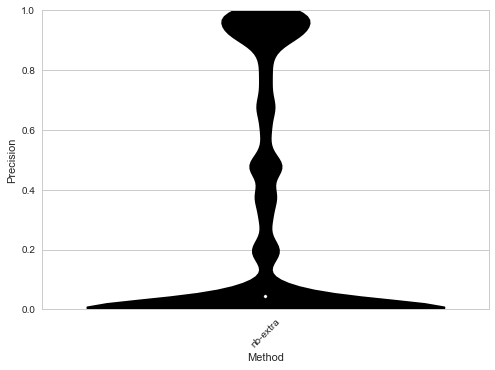

In [19]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Precision", color_pallette=color_pallette)

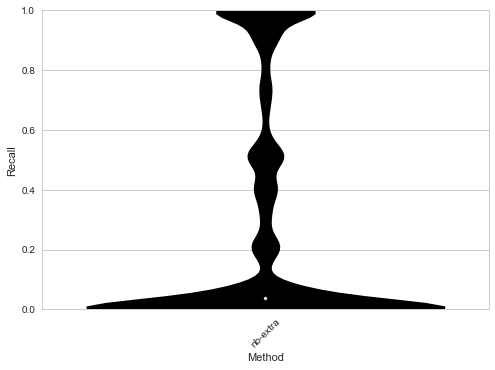

In [20]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Recall", color_pallette=color_pallette)

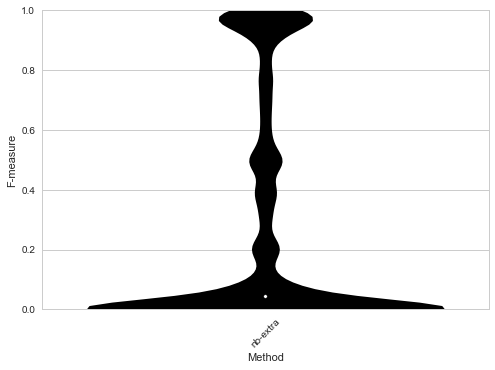

In [21]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="F-measure", color_pallette=color_pallette)

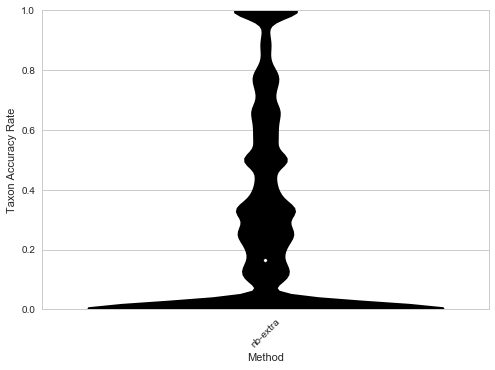

In [22]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Taxon Accuracy Rate", color_pallette=color_pallette)

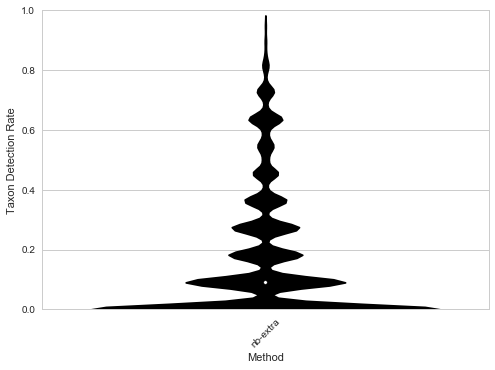

In [23]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Taxon Detection Rate", color_pallette=color_pallette)

### Method Optimization
Which method/parameter configuration performed "best" for a given score? We can rank the top-performing configuration by dataset, method, and taxonomic level.

First, the top-performing method/configuration combination by dataset.

In [24]:
for i in [n for n in range(1,27)]:
    display(Markdown('## mock-{0}'.format(i)))
    best = method_by_dataset_a1(mock_results_6, 'mock-{0}'.format(i))
    display(best)

## mock-1

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-2

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-3

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
1815209,nb-extra,"0.001:prior:65536:[8,8]:l2:True:0.4",1.0,1.0,1.0,1.0,0.7


## mock-4

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-5

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-6

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-7

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-8

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-9

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-10

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-11

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-12

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
5489,nb-extra,"0.01:uniform:1024:[16,16]:l2:True:0.4",0.995096,0.954609,0.974432,0.295455,0.619048


## mock-13

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-14

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-15

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-16

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-17

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-18

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
39219,nb-extra,"0.1:prior:1024:[8,8]:l2:True:0.6",0.99998,1.0,0.99999,0.8125,0.866667


## mock-19

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-20

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-21

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-22

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
74449,nb-extra,"0.001:prior:65536:[16,16]:l2:True:0.8",0.999744,0.885041,0.938902,0.62963,0.894737


## mock-23

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-24

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
103099,nb-extra,"0.1:prior:8192:[4,16]:l2:True:0.8",1.0,0.889646,0.941601,0.5,0.125


## mock-25

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


## mock-26

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate


Now we can determine which parameter configuration performed best for each method. *Count best* values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [25]:
for method in mock_results_6['Method'].unique():
    top_params = parameter_comparisons(
        mock_results_6, method, 
        metrics=['Precision', 'Recall', 'F-measure',
                 'Taxon Accuracy Rate', 'Taxon Detection Rate'])
    display(Markdown('## {0}'.format(method)))
    display(top_params[:10])

## nb-extra

,F-measure,Precision,Recall,Taxon Accuracy Rate,Taxon Detection Rate
"0.01:prior:1024:[8,8]:l2:False:0.0",139.0,125.0,145.0,145.0,74.0
"0.01:prior:65536:[8,8]:l2:True:0.2",140.0,126.0,146.0,51.0,74.0
"0.01:prior:65536:[8,8]:l2:True:0.0",140.0,126.0,146.0,51.0,74.0
"0.1:prior:1024:[8,8]:l2:True:0.0",139.0,125.0,145.0,159.0,73.0
"0.1:prior:8192:[8,8]:l2:True:0.0",140.0,126.0,146.0,130.0,73.0
"0.1:prior:8192:[8,8]:l2:True:0.2",140.0,126.0,146.0,127.0,73.0
"0.01:prior:1024:[16,16]:l2:False:0.0",135.0,121.0,141.0,143.0,72.0
"0.01:prior:8192:[8,8]:l2:False:0.0",140.0,126.0,146.0,86.0,72.0
"0.1:prior:1024:[16,16]:l2:True:0.2",135.0,121.0,141.0,147.0,72.0
"0.1:prior:1024:[16,16]:l2:True:0.0",135.0,121.0,141.0,149.0,72.0


In [26]:
uniform_6 = mock_results_6[['uniform' in p for p in mock_results_6['Parameters']]]
for method in uniform_6['Method'].unique():
    top_params = parameter_comparisons(
        uniform_6, method, 
        metrics=['Precision', 'Recall', 'F-measure',
                 'Taxon Accuracy Rate', 'Taxon Detection Rate'])
    display(Markdown('## {0}'.format(method)))
    display(top_params[:10])

## nb-extra

,F-measure,Precision,Recall,Taxon Accuracy Rate,Taxon Detection Rate
"0.001:uniform:65536:[8,8]:l2:True:0.4",65.0,60.0,72.0,73.0,74.0
"0.001:uniform:8192:[8,8]:l2:False:0.2",63.0,58.0,71.0,72.0,74.0
"0.1:uniform:65536:[8,8]:None:True:0.8",63.0,56.0,73.0,70.0,74.0
"0.1:uniform:65536:[8,8]:None:True:0.6",63.0,56.0,73.0,70.0,74.0
"0.1:uniform:65536:[8,8]:None:True:0.4",63.0,56.0,73.0,70.0,74.0
"0.1:uniform:65536:[8,8]:None:True:0.2",63.0,56.0,73.0,70.0,74.0
"0.1:uniform:65536:[8,8]:None:True:0.0",63.0,56.0,73.0,70.0,74.0
"0.01:uniform:8192:[8,8]:l2:True:0.0",63.0,57.0,69.0,70.0,74.0
"0.001:uniform:8192:[8,8]:l2:False:0.0",63.0,58.0,71.0,71.0,74.0
"0.001:uniform:65536:[8,8]:l2:True:0.0",63.0,58.0,72.0,70.0,74.0


## Optimized method performance
And, finally, which method performed best at each individual taxonomic level for each reference dataset (i.e., for across all fungal and bacterial mock communities combined)?

For this analysis, we rank the top-performing method/parameter combination for each method at family through species levels. Methods are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered, unless if you wish to change the *metric* used for sorting best methods and for plotting.

## gg_13_8_otus_amplicon level 4

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.001:prior:65536:[16,16]:l2:True:0.8",0.79959,0.829692,0.999721,0.999976,0.999848


,Method A,Method B,P


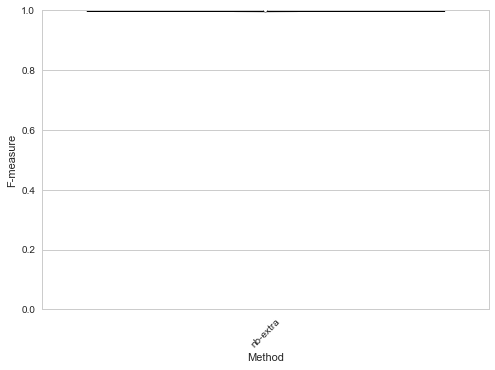

## gg_13_8_otus_amplicon level 5

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.01:prior:1024:[8,8]:l2:True:0.6",0.816088,0.800213,0.993622,0.993945,0.993784


,Method A,Method B,P


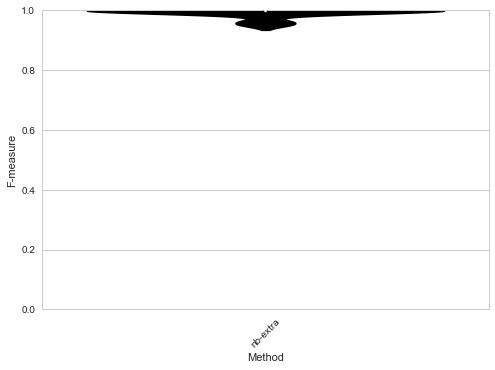

## gg_13_8_otus_amplicon level 6

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.001:prior:1024:[16,16]:l2:False:0.4",0.879643,0.787719,0.968601,0.969304,0.968952


,Method A,Method B,P


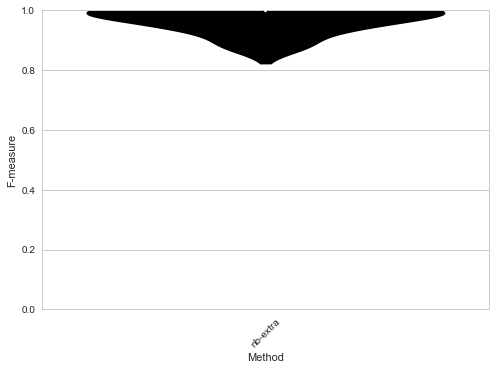

## gg_13_8_otus_full level 4

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.001:uniform:65536:[8,8]:l2:False:0.8",0.783437,0.829692,0.999728,0.999987,0.999857


,Method A,Method B,P


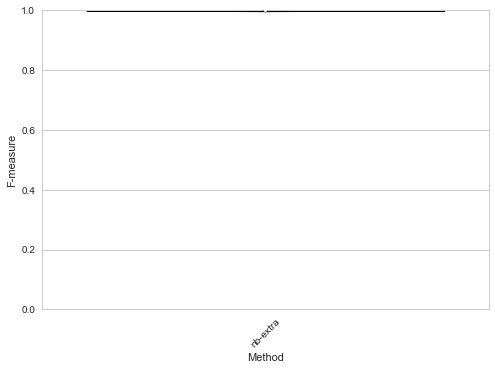

## gg_13_8_otus_full level 5

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.01:prior:8192:[8,8]:l2:False:0.8",0.818158,0.790009,0.993642,0.993903,0.993772


,Method A,Method B,P


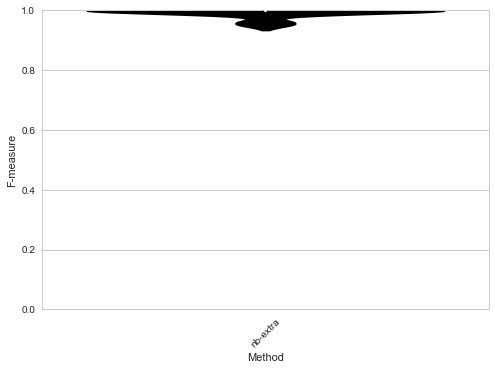

## gg_13_8_otus_full level 6

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.001:prior:8192:[8,8]:l2:False:0.2",0.861703,0.783638,0.976765,0.977484,0.977124


,Method A,Method B,P


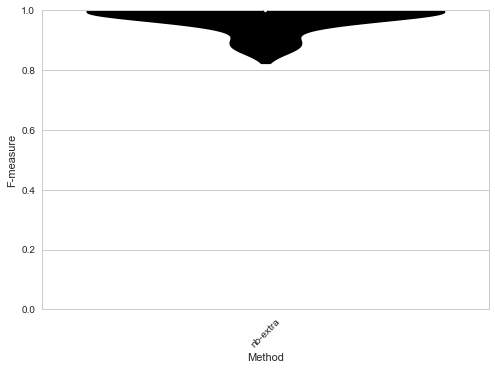

## gg_13_8_otus_read level 4

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.01:uniform:8192:[16,16]:l2:True:0.6",0.782342,0.829692,0.999724,0.999972,0.999848


,Method A,Method B,P


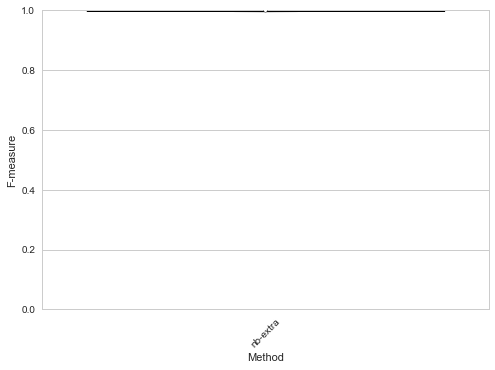

## gg_13_8_otus_read level 5

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.01:prior:1024:[8,8]:l2:True:0.6",0.810208,0.800213,0.993659,0.993945,0.993802


,Method A,Method B,P


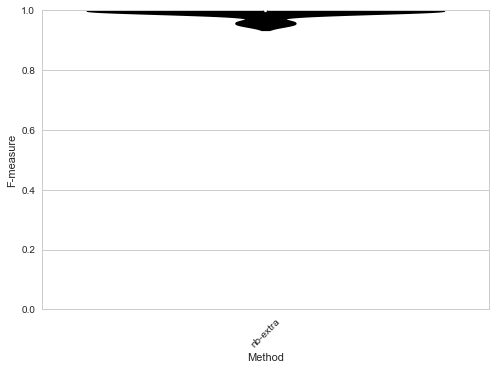

## gg_13_8_otus_read level 6

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.001:prior:1024:[8,8]:l2:False:0.4",0.871071,0.787719,0.968596,0.969297,0.968946


,Method A,Method B,P


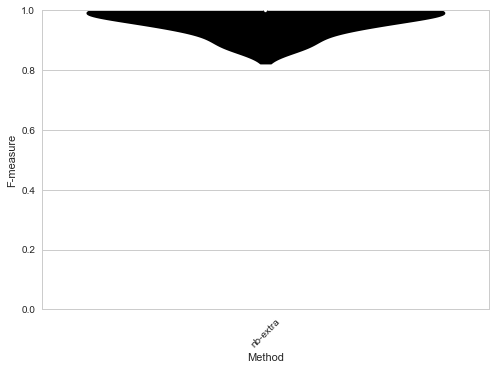

## unite_20.11.2016_clean_amplicon level 4

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.001:prior:65536:[4,16]:l2:False:0.8",0.723485,0.54717,0.907487,0.921429,0.912529


,Method A,Method B,P


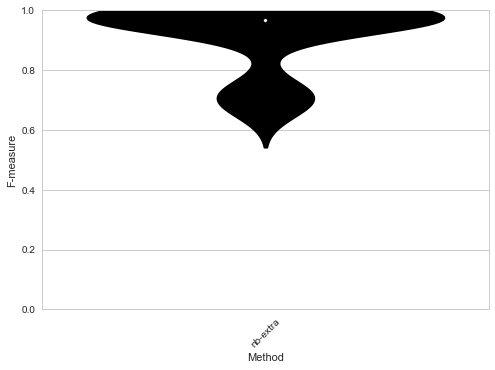

## unite_20.11.2016_clean_amplicon level 5

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.001:prior:65536:[4,16]:l2:False:0.8",0.700848,0.526587,0.873847,0.891686,0.881093


,Method A,Method B,P


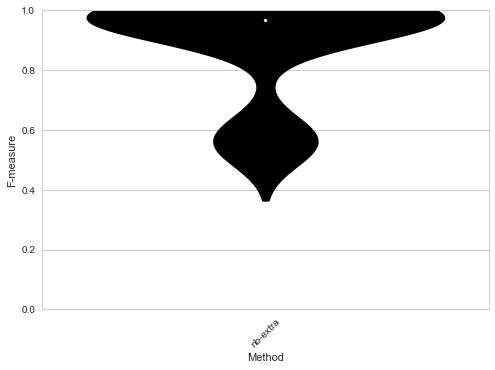

## unite_20.11.2016_clean_amplicon level 6

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.1:prior:1024:[8,8]:l2:False:0.4",0.540731,0.256218,0.975314,0.674285,0.725063


,Method A,Method B,P


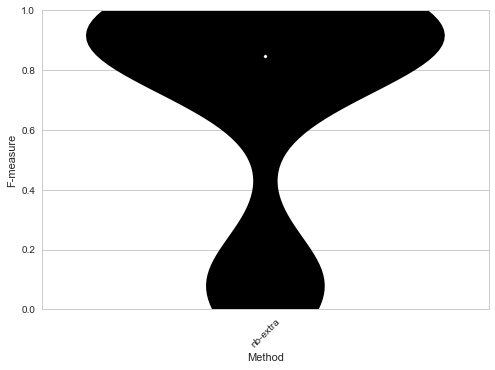

## unite_20.11.2016_clean_full level 4

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.1:prior:8192:[16,16]:l2:True:0.8",0.817835,0.539819,0.985147,0.997707,0.991269


,Method A,Method B,P


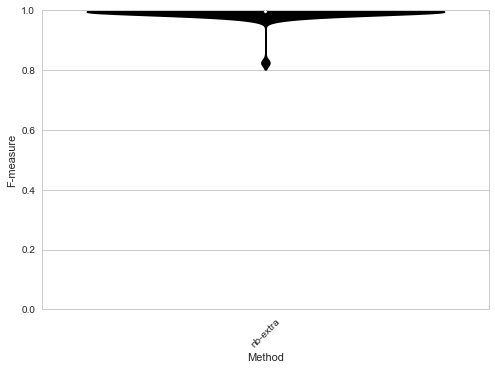

## unite_20.11.2016_clean_full level 5

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.1:prior:8192:[16,16]:l2:True:0.8",0.817835,0.538808,0.985147,0.997707,0.991269


,Method A,Method B,P


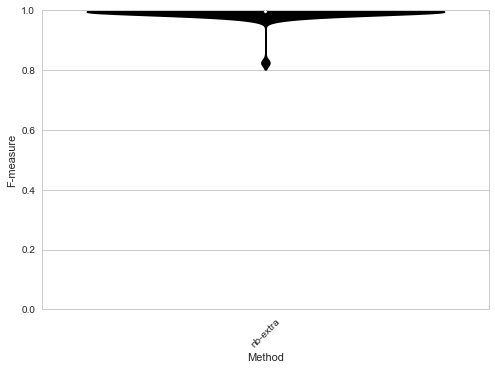

## unite_20.11.2016_clean_full level 6

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.1:prior:8192:[16,16]:l2:True:0.8",0.817835,0.538808,0.985147,0.997707,0.991269


,Method A,Method B,P


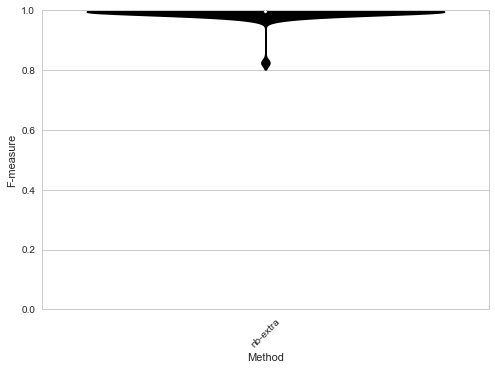

## unite_20.11.2016_clean_read level 4

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.001:prior:65536:[8,8]:l2:True:0.8",0.752057,0.472678,0.84,0.786714,0.777958


,Method A,Method B,P


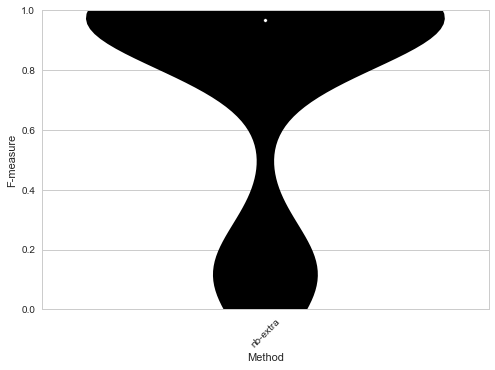

## unite_20.11.2016_clean_read level 5

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.001:prior:65536:[8,8]:l2:True:0.6",0.730044,0.472341,0.840278,0.786714,0.778107


,Method A,Method B,P


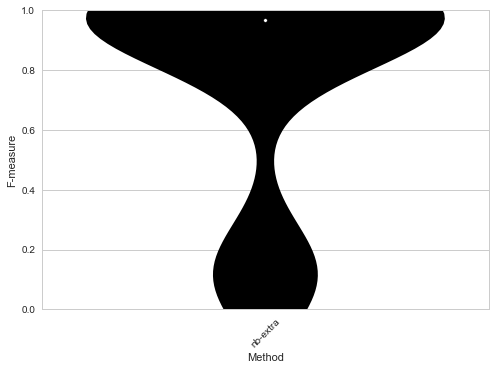

## unite_20.11.2016_clean_read level 6

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.01:prior:8192:[4,16]:l2:True:0.6",0.399013,0.257933,0.809594,0.674285,0.720384


,Method A,Method B,P


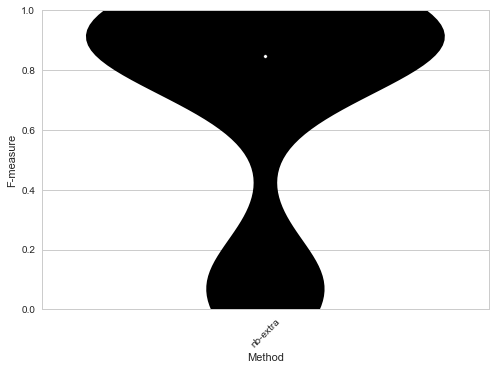

In [27]:
rank_optimized_method_performance_by_dataset(mock_results,
                                             dataset="Reference",
                                             metric="F-measure",
                                             level_range=range(4,7),
                                             display_fields=["Method",
                                                             "Parameters",
                                                             "Taxon Accuracy Rate",
                                                             "Taxon Detection Rate",
                                                             "Precision",
                                                             "Recall",
                                                             "F-measure"],
                                             paired=True,
                                             parametric=True,
                                             color=None,
                                             color_pallette=color_pallette)

## gg_13_8_otus_amplicon level 6

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.1:prior:65536:[4,4]:l1:True:0.0",1.0,0.107555,0.50601,0.506222,0.506116


,Method A,Method B,P


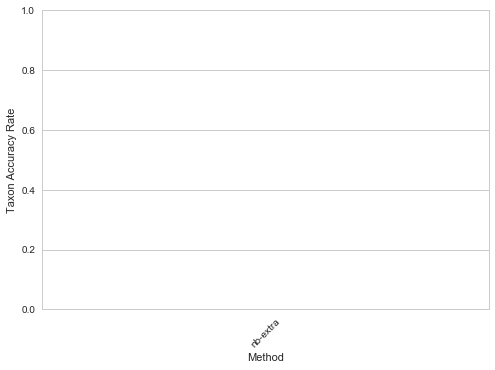

## gg_13_8_otus_full level 6

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.1:prior:1024:[4,4]:l1:True:0.0",1.0,0.071464,0.449513,0.449712,0.449613


,Method A,Method B,P


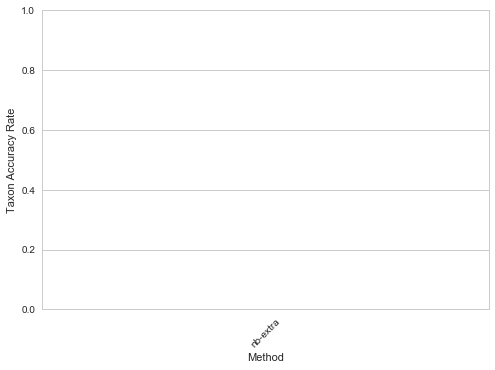

## gg_13_8_otus_read level 6

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,nb-extra,"0.1:prior:65536:[4,4]:l1:True:0.0",1.0,0.12184,0.506509,0.506721,0.506615


,Method A,Method B,P


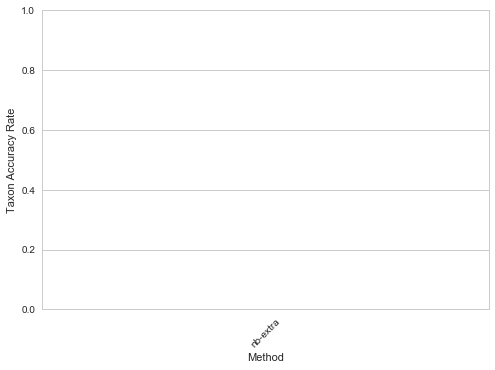

In [38]:
rank_optimized_method_performance_by_dataset(mock_results,
                                             dataset="Reference",
                                             metric="Taxon Accuracy Rate",
                                             level_range=range(6,7),
                                             display_fields=["Method",
                                                             "Parameters",
                                                             "Taxon Accuracy Rate",
                                                             "Taxon Detection Rate",
                                                             "Precision",
                                                             "Recall",
                                                             "F-measure"],
                                             paired=True,
                                             parametric=True,
                                             color=None,
                                             color_pallette=color_pallette)

## Beta diversity method/parameter comparisons
Principal coordinate analysis offers a neat way to assess the relative performance of multiple methods to reconstruct expected compositions. Methods that cluster with the "expected" composition probably outperform those that appear more distant on a PCoA plot. First, we need to merge biom tables from each method/parameter configuration for each dataset/reference/level combination, so that we can compare each method/parameter as a separate "sample".

__*Note: if you have added additional methods and are attempting to recompute results, set force=True.*__


In [ ]:
merge_expected_and_observed_tables(expected_results_dir, results_dirs, taxonomy_level=6, force=False)

Now we can manually select which table we want to view. This will output a Bray-Curtis PCoA plot, in addition to ANOSIM test results, which indicate whether at least two methods are significantly different from each other.

These plots are useful for visualizing the relative performance of different methods and their configurations relative to each other and to expected compositions, but are primarily a qualitative technique and do not really give us an idea of whether method X actually performs better than method Y.

__*Note that 2D plots will only appear if you are running notebooks locally. If viewing static notebooks online, make sure you are viewing this notebook in [nbviewer](http://nbviewer.jupyter.org/). (if viewing on GitHub, just copy the URL and paste into the search bar in nbviewer.)*__

In [195]:
table = join(expected_results_dir, 'mock-18', 'gg_13_8_otus', 'merged_table.biom')
sample_md, results, pc, dm = beta_diversity_pcoa(table, method="braycurtis", dim=2,
                                                 permutations=99, col='method', 
                                                 colormap=color_pallette)

R =  0.107665960452 ; P =  0.02


/Users/nbokulich/miniconda3/envs/q2-test/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.425058725719815 and the largest is 4.417440878355716.
  RuntimeWarning


Loading BokehJS ...

You can also view all beta diversity plots with a single command, ``batch_beta_diversity()``, but we will only show single dataset examples in these example notebooks.

### Average dissimilarity between expected results and observed results for each method 


As we already discussed, PCoA plots are good for a qualitative overview, but don't offer much in the way of quantitative comparison. Instead, we can directly compare the Bray-Curtis dissimilarity between methods, and utilize pairwise Mann-Whitney U tests to determine precisely which methods perform better (**lower dissimilarity = more accurate classification**). In the cell below, we will use distance comparisons to determine:

    1) Whether the dissimilarity between taxonomic assignment with different parameters of the same method is greater or less than the dissimilarity between taxonomic assignments with different methods, including the expected composition.
    2) which method (averaged across all configurations) most closely reproduces the expected composition.
    
You can generate boxplots for individual datasets one-by-one with ``per_method_boxplots()``, or for all datasets individually with ``fastlane_boxplots()``. However, here we are most interested in the average performance of methods across each dataset.

The command below violin plots of distribution of distances between expected composition and predicted compositions for each method (all parameter configurations) across all samples/datasets, and pairwise Mann Whitney U tests between these distributions.

## gg_13_8_otus

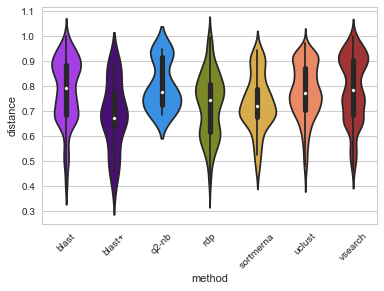

,method A,method B,P
0,blast+,blast,4.613902e-06
1,blast+,q2-nb,7.597099e-01
2,blast+,rdp,1.509068e-08
3,blast+,sortmerna,1.270810e-05
4,blast+,uclust,8.736689e-01
5,blast+,vsearch,7.519476e-01
6,blast,q2-nb,1.313426e-04
7,blast,rdp,2.478060e-01
8,blast,sortmerna,7.161906e-02
9,blast,uclust,1.421662e-07


## unite_20.11.2016_clean_fullITS

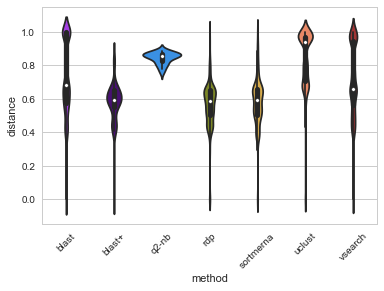

,method A,method B,P
0,blast+,blast,0.000000
1,blast+,q2-nb,0.013377
2,blast+,rdp,0.000000
3,blast+,sortmerna,0.000000
4,blast+,uclust,0.000000
5,blast+,vsearch,0.642323
6,blast,q2-nb,0.000000
7,blast,rdp,0.658687
8,blast,sortmerna,0.737130
9,blast,uclust,0.000000


None

In [196]:
results = average_distance_boxplots(expected_results_dir, paired=False,
                                    use_best=False, color_pallette=color_pallette)
display(results)

### Average distance between expected results and observed results for each method with optimized parameters 
Reports the top-performing parameter configuration for each method, violin plots of distribution of distances between expected composition and predicted compositions for the top parameter for each method across all samples/datasets, and pairwise paired Wilcoxon signed rank tests between these distributions.

## gg_13_8_otus

,method,params
0,blast+,0.001:1:0.99:0.8
1,blast,1000
2,q2-nb,0.0
3,rdp,0.3
4,sortmerna,0.51:0.99:1:0.9:1.0
5,uclust,0.76:0.9:1
6,vsearch,1:0.99:0.99


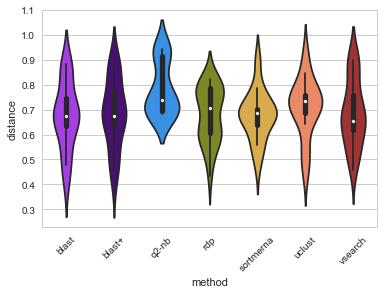

,method A,method B,P
0,blast+,blast,0.288080
1,blast+,q2-nb,1.000000
2,blast+,rdp,1.000000
3,blast+,sortmerna,1.000000
4,blast+,uclust,0.431959
5,blast+,vsearch,0.836601
6,blast,q2-nb,1.000000
7,blast,rdp,0.999999
8,blast,sortmerna,0.999999
9,blast,uclust,0.754548


## unite_20.11.2016_clean_fullITS

,method,params
0,blast+,0.001:1:0.99:0.99
1,blast,1000
2,q2-nb,0.0
3,rdp,0.3
4,sortmerna,1.0:0.99:5:0.9:1.0
5,uclust,1.0:0.9:1
6,vsearch,1:0.99:0.99


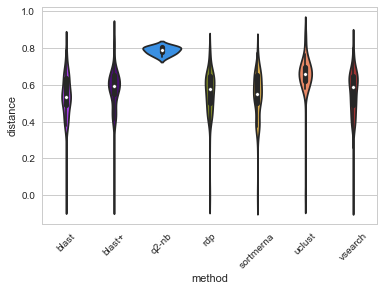

,method A,method B,P
0,blast+,blast,0.000000e+00
1,blast+,q2-nb,1.000000e+00
2,blast+,rdp,0.000000e+00
3,blast+,sortmerna,3.057254e-02
4,blast+,uclust,0.000000e+00
5,blast+,vsearch,4.109293e-07
6,blast,q2-nb,1.000000e+00
7,blast,rdp,3.491831e-07
8,blast,sortmerna,4.263256e-14
9,blast,uclust,2.275840e-10


In [198]:
results = average_distance_boxplots(expected_results_dir,
                                    color_pallette=color_pallette)
results